In [23]:
import time

from data import create_dataset
from models import create_model

import argparse

import numpy as np


import os
from util.visualizer import save_images
from util import html

import matplotlib.pyplot as plt


### Pix2Pix

In [24]:
class OPT:
    def __init__(self):
        self.batch_size=1 
        self.beta1=0.5
        self.checkpoints_dir='./checkpoints'
        self.continue_train=False
        self.crop_size=256
        self.dataroot='./datasets/facades'
        self.dataset_mode='aligned'
        self.direction='BtoA'
        self.display_env='main' 
        self.display_freq=400
        self.display_id=1
        self.display_ncols=4 
        self.display_port=8097
        self.display_server='http://localhost'
        self.display_winsize=256
        self.epoch='latest'
        self.epoch_count=1 
        self.gan_mode='vanilla' 
        self.gpu_ids=[0]
        self.init_gain=0.02 
        self.init_type='normal' 
        self.input_nc=3
        self.isTrain=True 
        self.lambda_L1=100.0 
        self.load_iter=0
        self.load_size=286 
        self.lr=0.0002
        self.lr_decay_iters=50
        self.lr_policy='linear' 
        self.max_dataset_size=float("inf")
        self.model='pix2pix'
        #just for demonstration it was around 100 + 100 for training
        self.n_epochs=5
        self.n_epochs_decay=5
        self.n_layers_D=3
        self.name='facades_pix2pix' 
        self.ndf=64
        self.netD='basic'
        self.netG='unet_256'
        self.ngf=64
        self.no_dropout=False
        self.no_flip=False
        self.no_html=False 
        self.norm='batch'
        self.num_threads=4 
        self.output_nc=3
        self.phase='train' 
        self.pool_size=0
        self.preprocess='resize_and_crop'
        self.print_freq=100
        self.save_by_iter=False
        self.save_epoch_freq=5 
        self.save_latest_freq=5000
        self.serial_batches=False
        self.suffix=''
        self.update_html_freq=1000
        self.verbose=False

        
class OPTTEST:
    def __init__(self):
        self.aspect_ratio=1.0
        self.batch_size=1
        self.checkpoints_dir='./checkpoints'
        self.crop_size=256
        self.dataroot='./datasets/facades'
        self.dataset_mode='aligned'
        self.direction='BtoA'
        self.display_winsize=256
        self.epoch='latest'
        self.eval=False
        self.gpu_ids=[0] 
        self.init_gain=0.02 
        self.init_type='normal' 
        self.input_nc=3
        self.isTrain=False 
        self.load_iter=0
        self.load_size=256 
        self.max_dataset_size=float("inf")
        self.model='pix2pix'
        self.n_layers_D=3
        self.name='facades_label2photo_pretrained'
        self.ndf=64
        self.netD='basic'
        self.netG='unet_256' 
        self.ngf=64
        self.no_dropout=False
        self.no_flip=False
        self.norm='batch' 
        self.num_test=50 
        self.num_threads=4
        self.output_nc=3 
        self.phase='test' 
        self.preprocess='resize_and_crop' 
        self.results_dir='./results/'
        self.serial_batches=False
        self.suffix=''
        self.verbose=False

In [25]:

opt = OPT()
dataset = create_dataset(opt)
dataset_size = len(dataset)
print('The number of training images = %d' % dataset_size)

model = create_model(opt)
model.setup(opt)
total_iters = 0

for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):
    epoch_start_time = time.time()
    iter_data_time = time.time()
    epoch_iter = 0
    model.update_learning_rate()
    G_GAN = []
    G_L1 = []
    D_real = []
    D_fake = []
    for i, data in enumerate(dataset):


        iter_start_time = time.time()
        if total_iters % opt.print_freq == 0:
            t_data = iter_start_time - iter_data_time

        total_iters += opt.batch_size
        epoch_iter += opt.batch_size
        model.set_input(data)
        model.optimize_parameters()
        
        if total_iters % opt.display_freq == 0:
            save_result = total_iters % opt.update_html_freq == 0
            model.compute_visuals()

        if total_iters % opt.print_freq == 0:
            losses = model.get_current_losses()
            t_comp = (time.time() - iter_start_time) / opt.batch_size

            G_GAN.append(losses['G_GAN'])
            G_L1.append(losses['G_L1'])
            D_real.append(losses['D_real'])
            D_fake.append(losses['D_fake'])
            

        if total_iters % opt.save_latest_freq == 0:
            print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
            save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
            model.save_networks(save_suffix)
        

        iter_data_time = time.time()
    
    if epoch % opt.save_epoch_freq == 0:
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
        model.save_networks('latest')
        model.save_networks(epoch)
    
    
    print("Epoch: {0}, G_GAN: {1}, G_LI: {2}, D_real {3}, D_fake {4}".format(epoch, 
                    np.mean(G_GAN), np.mean(G_L1), np.mean(D_real), np.mean(D_fake)))
    

    print('End of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.n_epochs + opt.n_epochs_decay, time.time() - epoch_start_time))


dataset [AlignedDataset] was created
The number of training images = 400
initialize network with normal
initialize network with normal
model [Pix2PixModel] was created
---------- Networks initialized -------------
[Network G] Total number of parameters : 54.414 M
[Network D] Total number of parameters : 2.769 M
-----------------------------------------------
learning rate 0.0002000 -> 0.0002000
Epoch: 1, G_GAN: 3.0246872305870056, G_LI: 34.385597229003906, D_real 0.19930771132931113, D_fake 0.11433223262429237
End of epoch 1 / 10 	 Time Taken: 20 sec
learning rate 0.0002000 -> 0.0002000
Epoch: 2, G_GAN: 2.534096211194992, G_LI: 38.33569812774658, D_real 0.14112888928502798, D_fake 0.20235158689320087
End of epoch 2 / 10 	 Time Taken: 20 sec
learning rate 0.0002000 -> 0.0002000
Epoch: 3, G_GAN: 2.4346024692058563, G_LI: 32.316704750061035, D_real 0.24966872698860243, D_fake 0.20826119184494019
End of epoch 3 / 10 	 Time Taken: 20 sec
learning rate 0.0002000 -> 0.0002000
Epoch: 4, G_GAN:

In [26]:
opt = OPTTEST()

print(opt)
opt.num_threads = 0   
opt.batch_size = 1    
opt.serial_batches = True 
opt.no_flip = True   
opt.display_id = -1   
dataset = create_dataset(opt) 
model = create_model(opt)     
model.setup(opt)             

web_dir = os.path.join(opt.results_dir, opt.name, '{}_{}'.format(opt.phase, opt.epoch)) 
if opt.load_iter > 0:  
    web_dir = '{:s}_iter{:d}'.format(web_dir, opt.load_iter)
print('creating web directory', web_dir)
webpage = html.HTML(web_dir, 'Experiment = %s, Phase = %s, Epoch = %s' % (opt.name, opt.phase, opt.epoch))
if opt.eval:
    model.eval()
for i, data in enumerate(dataset):
    if i >= opt.num_test:  
        break
    model.set_input(data) 
    model.test()          
    visuals = model.get_current_visuals()
    img_path = model.get_image_paths()  
    if i % 5 == 0: 
        print('processing (%04d)-th image... %s' % (i, img_path))
    save_images(webpage, visuals, img_path, aspect_ratio=opt.aspect_ratio, width=opt.display_winsize)
webpage.save() 


dataset [AlignedDataset] was created
initialize network with normal
model [Pix2PixModel] was created
loading the model from ./checkpoints/facades_label2photo_pretrained/latest_net_G.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 54.414 M
-----------------------------------------------
creating web directory ./results/facades_label2photo_pretrained/test_latest
processing (0000)-th image... ['./datasets/facades/test/1.jpg']
processing (0005)-th image... ['./datasets/facades/test/103.jpg']
processing (0010)-th image... ['./datasets/facades/test/12.jpg']
processing (0015)-th image... ['./datasets/facades/test/17.jpg']
processing (0020)-th image... ['./datasets/facades/test/21.jpg']
processing (0025)-th image... ['./datasets/facades/test/26.jpg']
processing (0030)-th image... ['./datasets/facades/test/30.jpg']
processing (0035)-th image... ['./datasets/facades/test/35.jpg']
processing (0040)-th image... ['./datasets/facades/test/4.jpg']
processing

## Prediction pix2pix

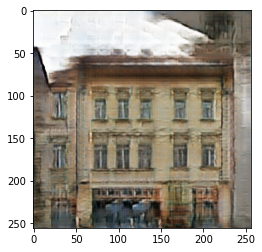

In [27]:
img = plt.imread('./results/facades_label2photo_pretrained/test_latest/images/101_fake_B.png')
plt.imshow(img)

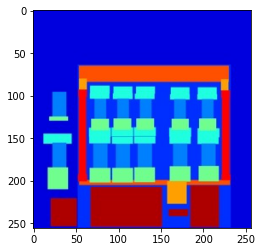

In [28]:
img = plt.imread('./results/facades_label2photo_pretrained/test_latest/images/101_real_A.png')
plt.imshow(img)


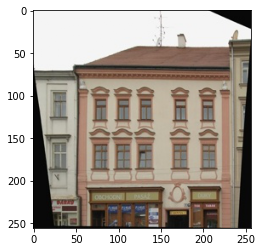

In [29]:
img = plt.imread('./results/facades_label2photo_pretrained/test_latest/images/101_real_B.png')
plt.imshow(img)

### CycleGAN

In [30]:
opt = OPT()

opt.checkpoints_dir='./checkpoints_cycle'

opt.model='cycle_gan'

opt.name='facades_cycle_gan'

opt.lambda_identity = 0

opt.lambda_A = 0.1
opt.lambda_B = 0.1

In [31]:
dataset = create_dataset(opt)
dataset_size = len(dataset)
print('The number of training images = %d' % dataset_size)

model = create_model(opt)
model.setup(opt)
total_iters = 0

for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):
    epoch_start_time = time.time()
    iter_data_time = time.time()
    epoch_iter = 0
    model.update_learning_rate()
    loss_v = []
    for i, data in enumerate(dataset):



        iter_start_time = time.time()
        if total_iters % opt.print_freq == 0:
            t_data = iter_start_time - iter_data_time

        total_iters += opt.batch_size
        epoch_iter += opt.batch_size
        model.set_input(data)
        model.optimize_parameters()
        
        if total_iters % opt.display_freq == 0:
            save_result = total_iters % opt.update_html_freq == 0
            model.compute_visuals()

        if total_iters % opt.print_freq == 0:
            losses = model.get_current_losses()
            t_comp = (time.time() - iter_start_time) / opt.batch_size
            
            loss_v.append(t_comp)

            

        if total_iters % opt.save_latest_freq == 0:
            print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
            save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
            model.save_networks(save_suffix)
            
        

        iter_data_time = time.time()
    print("Epoch :{0}. Loss {1}".format(epoch, np.mean(loss_v)))
    
    if epoch % opt.save_epoch_freq == 0:
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
        model.save_networks('latest')
        model.save_networks(epoch)
    
    


    print('End of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.n_epochs + opt.n_epochs_decay, time.time() - epoch_start_time))


dataset [AlignedDataset] was created
The number of training images = 400
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
model [CycleGANModel] was created
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 54.414 M
[Network G_B] Total number of parameters : 54.414 M
[Network D_A] Total number of parameters : 2.766 M
[Network D_B] Total number of parameters : 2.766 M
-----------------------------------------------
learning rate 0.0002000 -> 0.0002000
Epoch :1. Loss 0.18299943208694458
End of epoch 1 / 10 	 Time Taken: 57 sec
learning rate 0.0002000 -> 0.0002000
Epoch :2. Loss 0.18390095233917236
End of epoch 2 / 10 	 Time Taken: 57 sec
learning rate 0.0002000 -> 0.0002000
Epoch :3. Loss 0.18390429019927979
End of epoch 3 / 10 	 Time Taken: 58 sec
learning rate 0.0002000 -> 0.0002000
Epoch :4. Loss 0.18412047624588013
End of epoch 4 / 10 	 Time Taken: 58 sec
learning rate 0.0

In [32]:
opt = OPTTEST()
opt.checkpoints_dir='./checkpoints_cycle'

opt.dataroot='./datasets/facades'

opt.model='cycle_gan'

opt.name='facades_cycle_gan2photo_pretrained'


In [33]:


print(opt)
opt.num_threads = 0   
opt.batch_size = 1    
opt.serial_batches = True 
opt.no_flip = True   
opt.display_id = -1   
dataset = create_dataset(opt) 
model = create_model(opt)     
model.setup(opt)             

web_dir = os.path.join(opt.results_dir, opt.name, '{}_{}'.format(opt.phase, opt.epoch)) 
if opt.load_iter > 0:  
    web_dir = '{:s}_iter{:d}'.format(web_dir, opt.load_iter)
print('creating web directory', web_dir)
webpage = html.HTML(web_dir, 'Experiment = %s, Phase = %s, Epoch = %s' % (opt.name, opt.phase, opt.epoch))
if opt.eval:
    model.eval()
for i, data in enumerate(dataset):
    if i >= opt.num_test:  
        break
    model.set_input(data) 
    model.test()          
    visuals = model.get_current_visuals()
    img_path = model.get_image_paths()  
    if i % 5 == 0: 
        print('processing (%04d)-th image... %s' % (i, img_path))
    save_images(webpage, visuals, img_path, aspect_ratio=opt.aspect_ratio, width=opt.display_winsize)
webpage.save() 

dataset [AlignedDataset] was created
initialize network with normal
initialize network with normal
model [CycleGANModel] was created
loading the model from ./checkpoints_cycle/facades_cycle_gan2photo_pretrained/latest_net_G_A.pth
loading the model from ./checkpoints_cycle/facades_cycle_gan2photo_pretrained/latest_net_G_B.pth
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 54.414 M
[Network G_B] Total number of parameters : 54.414 M
-----------------------------------------------
creating web directory ./results/facades_cycle_gan2photo_pretrained/test_latest
processing (0000)-th image... ['./datasets/facades/test/1.jpg']
processing (0005)-th image... ['./datasets/facades/test/103.jpg']
processing (0010)-th image... ['./datasets/facades/test/12.jpg']
processing (0015)-th image... ['./datasets/facades/test/17.jpg']
processing (0020)-th image... ['./datasets/facades/test/21.jpg']
processing (0025)-th image... ['./datasets/facades/test/26.jpg']
proce

### Prediction CycleGAN

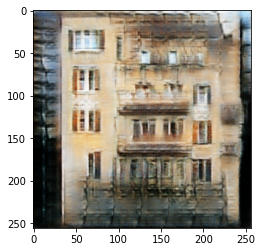

In [34]:

img = plt.imread('./results/facades_label2photo_pretrained/test_latest/images/105_fake_B.png')
plt.imshow(img)

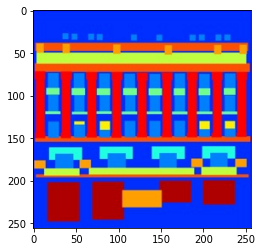

In [35]:
img = plt.imread('./results/facades_label2photo_pretrained/test_latest/images/103_real_A.png')
plt.imshow(img)

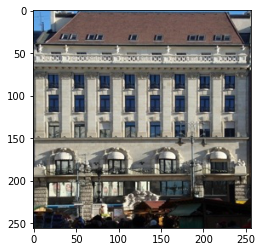

In [36]:
img = plt.imread('./results/facades_label2photo_pretrained/test_latest/images/103_real_B.png')
plt.imshow(img)